In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Xử lí dữ liệu

In [60]:
# Tải dữ liệu lịch sử của cổ phiếu (ví dụ: 'AAPL' cho Apple)
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-05-01")

# Tính giá trung bình
data['Price'] = data[['Open', 'Close', 'High', 'Low']].mean(axis=1)

# Chọn các cột cần thiết
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Price']]

# Kiểm tra giá trị bị thiếu
print(data.isna().sum())

# Xử lý giá trị bị thiếu (loại bỏ các hàng có giá trị bị thiếu)
data.dropna(inplace=True)

# Lưu dữ liệu vào tệp CSV
csv_file = f'{ticker}_historical_data.csv'
data.to_csv(csv_file)
print(f"Dữ liệu đã được lưu vào tệp {csv_file}")

# Đọc dữ liệu từ tệp CSV (Tuỳ chọn)
data_from_csv = pd.read_csv(csv_file, index_col=0)
print(data_from_csv.head())

# Chuẩn bị dữ liệu cho mô hình
prices = data_from_csv['Price'].values
volumes = data_from_csv['Volume'].values

# Chuẩn hóa dữ liệu
mean_price = np.mean(prices)
std_price = np.std(prices)
prices = (prices - mean_price) / std_price

# Căn chỉnh dữ liệu
volumes = volumes[1:]  # Loại bỏ phần tử đầu tiên của volumes
prices = prices[:-1]   # Loại bỏ phần tử cuối cùng của prices

# Số lượng mẫu
m = len(volumes)

[*********************100%%**********************]  1 of 1 completed

Open      0
High      0
Low       0
Close     0
Volume    0
Price     0
dtype: int64
Dữ liệu đã được lưu vào tệp AAPL_historical_data.csv
                 Open       High        Low      Close     Volume      Price
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  135480400  74.523750
2020-01-03  74.287498  75.144997  74.125000  74.357498  146322800  74.478748
2020-01-06  73.447502  74.989998  73.187500  74.949997  118387200  74.143749
2020-01-07  74.959999  75.224998  74.370003  74.597504  108872000  74.788126
2020-01-08  74.290001  76.110001  74.290001  75.797501  132079200  75.121876



C:\Users\admin\AppData\Local\Temp\ipykernel_8324\2919114991.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Gradient Descent

In [61]:
import random
# Khởi tạo tham số
b = random.random()
a = random.random()
alpha = 0.01  # Learning rate
epochs = 1000  # Số lần lặp

# Gradient Descent
for epoch in range(epochs):
    volume_pred = b + a * prices
    error = volume_pred - volumes
    db = (1/m) * np.sum(error)
    da = (1/m) * np.sum(error * prices)
    
    # Kiểm tra các giá trị không hợp lệ trước khi cập nhật
    if not np.isnan(db) and not np.isnan(da):
        b -= alpha * db
        a -= alpha * da
    else:
        print(f"Encountered NaN at epoch {epoch}")
        break

print(f"Hệ số b: {b}, hệ số a: {a}")


Hệ số b: -1.3437498046626851e+237, hệ số a: -2.0352376480781843e+239


Dự đoán

In [62]:
# Dự đoán volume sử dụng các hệ số vừa tìm được
volume_pred = b + a * prices

Tính toán

In [63]:
# Tính tổng bình phương của các phần dư (SSR)
ssr = np.sum((volume_pred - volumes) ** 2)
print(f"Tổng bình phương của các phần dư (SSR): {ssr}")

Tổng bình phương của các phần dư (SSR): inf


C:\Users\admin\AppData\Local\Temp\ipykernel_8324\3108405012.py:2: RuntimeWarning: overflow encountered in square
  ssr = np.sum((volume_pred - volumes) ** 2)


Sử dụng sklearn để so sánh

Tổng bình phương của các phần dư (SSR) với sklearn: 1.7753889198064906e+18
Hệ số hồi quy (intercept) với sklearn: 245849064.76384753
Hệ số hồi quy (slope) với sklearn: -1043618.1189253707


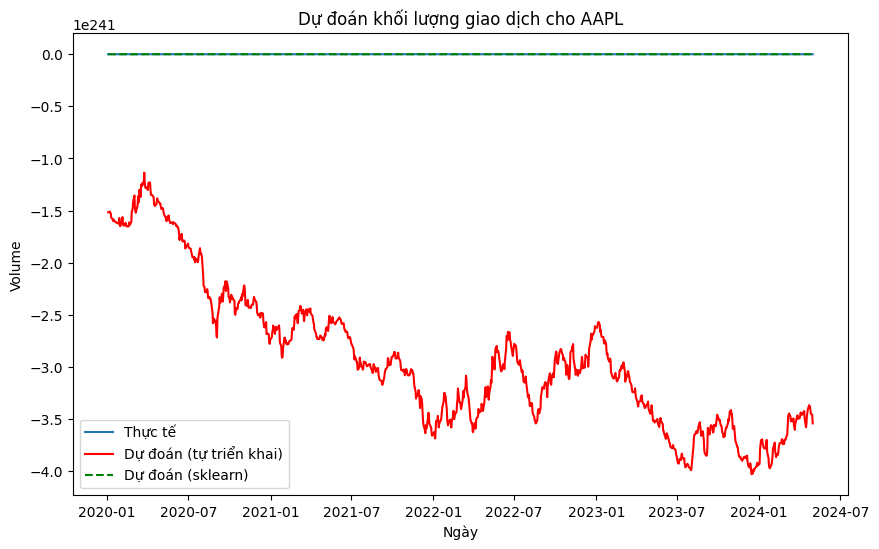

In [64]:
# Chuyển đổi prices thành dạng 2D cho sklearn
prices_reshaped = prices.reshape(-1, 1)

# Khởi tạo và huấn luyện mô hình LinearRegression của sklearn
model = LinearRegression()
model.fit(prices_reshaped, volumes)

# Dự đoán khối lượng giao dịch với sklearn
volumes_pred_sklearn = model.predict(prices_reshaped)

# Tính SSR cho mô hình sklearn
ssr_sklearn = mean_squared_error(volumes, volumes_pred_sklearn) * m
print(f"Tổng bình phương của các phần dư (SSR) với sklearn: {ssr_sklearn}")

# So sánh hệ số hồi quy
print(f"Hệ số hồi quy (intercept) với sklearn: {model.intercept_}")
print(f"Hệ số hồi quy (slope) với sklearn: {model.coef_[0]}")



Vẽ biểu đồ so sánh

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[1:], volumes, label='Thực tế')
plt.plot(data.index[1:], volume_pred, label='Dự đoán (tự triển khai)', color='r')
plt.plot(data.index[1:], volumes_pred_sklearn, label='Dự đoán (sklearn)', color='g', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Volume')
plt.title(f'Dự đoán khối lượng giao dịch cho {ticker}')
plt.legend()
plt.show()